![header(3).jpg](attachment:355a546d-c2ca-478e-a989-8aa5ce579dbc.jpg)

The WiDS Datathon 2023 can be viewed as a time series forecasting problem. In this data science competition, you are provided long-term weather data for multiple locations. The aim is to predict the average temperature over the next 2 weeks for each location for a given start date.

Time series forecasting has been approached with statistical methods since the 1950s (e.g. exponential smoothing, ARIMA, etc.). However, in recent years approaches using Machine Learning algorithms (hybrid models, neural networks, gradient boosted trees) have been shown to be more effective.

This Notebook will give you a **brief introduction to time series forecasting with a Machine Learning algorithm called LightGBM.**

# Import Libraries

Let's begin by importing the relevant libraries.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer

from datetime import datetime, timedelta

import lightgbm as lgb

import warnings # Supress warnings
warnings.filterwarnings("ignore")

> Here they imported necessary libraries for a data analysis or machine learning task.

- The code sets up the environment for data analysis or machine learning, importing essential libraries for data manipulation, visualization, and machine learning. It also includes modules for handling date and time. The inclusion of LightGBM suggests that the code may involve building a gradient boosting model using the LightGBM framework. The warnings are being suppressed to avoid cluttering the output with non-essential messages.

# Experiment Tracking Setup

This step is **optional** but tracking your ML experiments can help you develop your ML models more efficiently.
I'll be using Weights & Biases for experiment tracking.

**Disclaimer:** I am a W&B Ambassador

![Weights & Biases Black Text.png](attachment:c7352780-0028-404b-9905-e3325c1c79b1.png)


If you fork this notebook, you need to setup your own secrets API key `WANDB_API_KEY` to run this notebook.

If you don't have an W&B account yet, you can set up one for free.
To get your API key,
1. Go to https://wandb.ai/site and login
2. Click on your profile in the top right corner and select "Settings"
3. Scroll down to API keys and copy your key

For more details, to set up W&B, you can check out this notebook on [ML Experiment Tracking](https://www.kaggle.com/code/ayuraj/experiment-tracking-with-weights-and-biases/notebook).

If you are new to experiment tracking, you can leave out this step or you could start with tracking your experiments with pen and paper to keep an overview of what worked and what didn't.

In [ ]:
pip install wandb lightgbm

In [ ]:
!pip install --upgrade -q wandb

In [ ]:
from kaggle_secrets import UserSecretsClient
import wandb
from wandb.integration.lightgbm import log_summary, wandb_callback

# Setup user secrets for login
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("WANDB_API_KEY")

# Login
wandb.login(key = wandb_api)

ModuleNotFoundError: ignored


- this code is preparing the environment for integrating Weights & Biases with a LightGBM model. It retrieves the necessary API key from the user's secrets, logs into Weights & Biases, and sets the stage for tracking and visualizing the LightGBM model's training progress and performance.

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

- There were two ways you can login:

 here we ran a cell with wandb.login() in stead of kaggle secreat![Screenshot 2023-12-10 213432.png](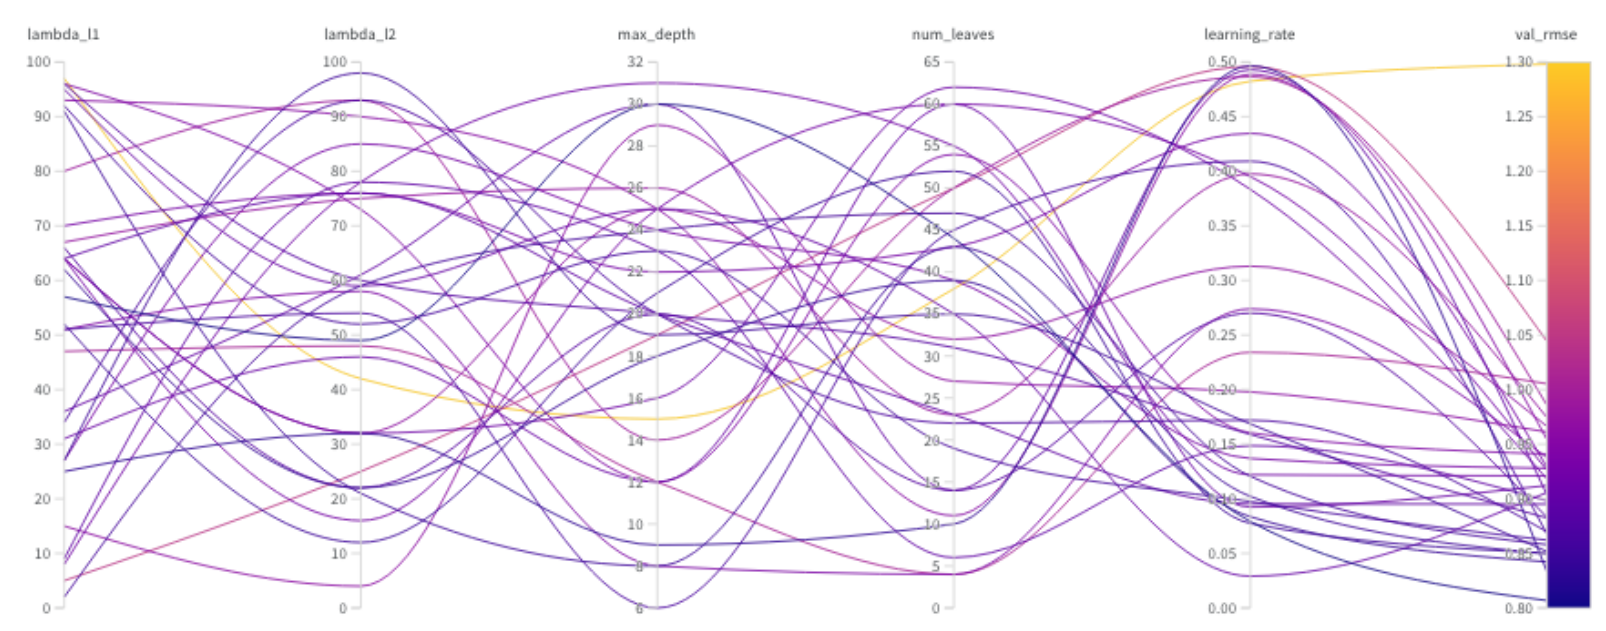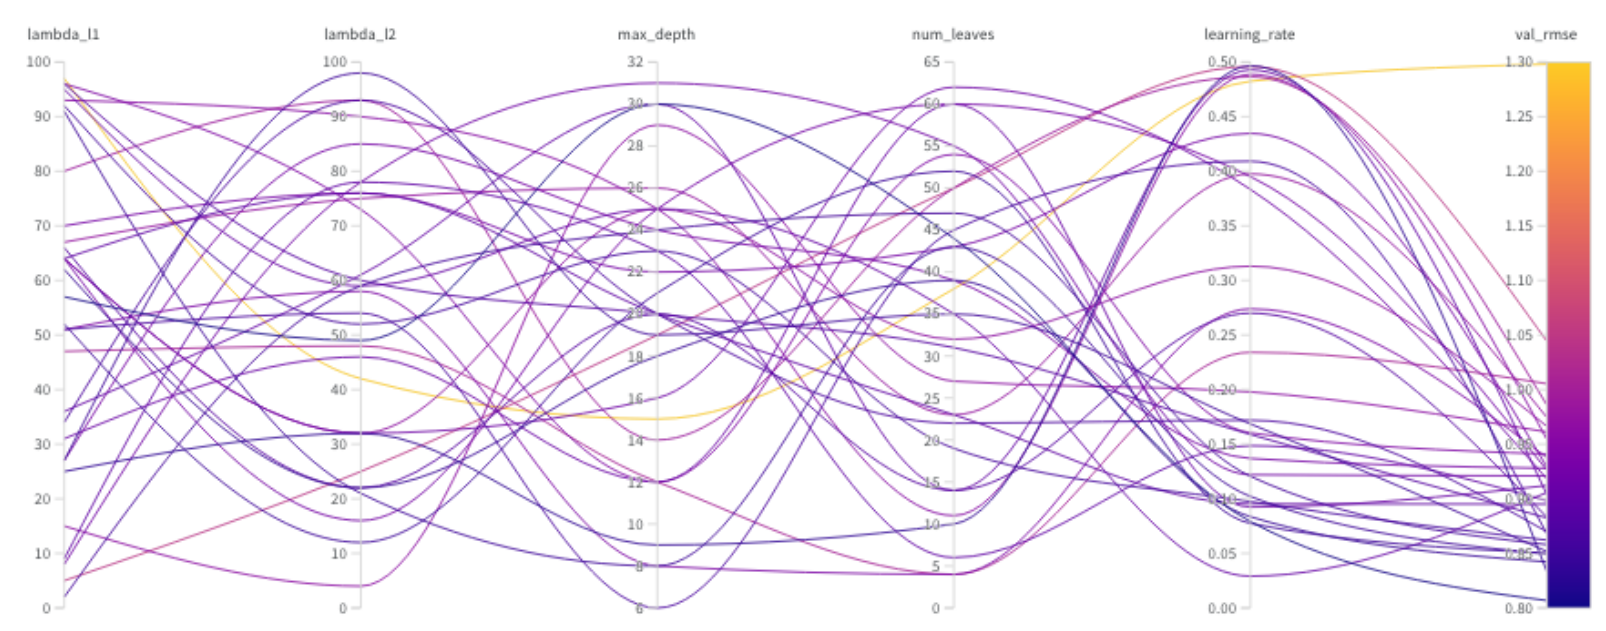)

# Load Data

Let's load the training and the test data. The training data is the data used to build our prediction model and the test data is the data for which we make the predictions.

In [ ]:
train_df = pd.read_csv('/content/sample_data/train_data.csv')
display(train_df.head().style.set_caption('Train data'))

test_df = pd.read_csv('/content/sample_data/test_data.csv')
display(test_df.head().style.set_caption('Test data'))

- This code is a common initial step.It loads training and testing datasets from CSV files and displays the first few rows of each dataset, providing a quick overview of the data's structure and content. This exploration is crucial for understanding the features, data types, and potential challenges in the dataset.

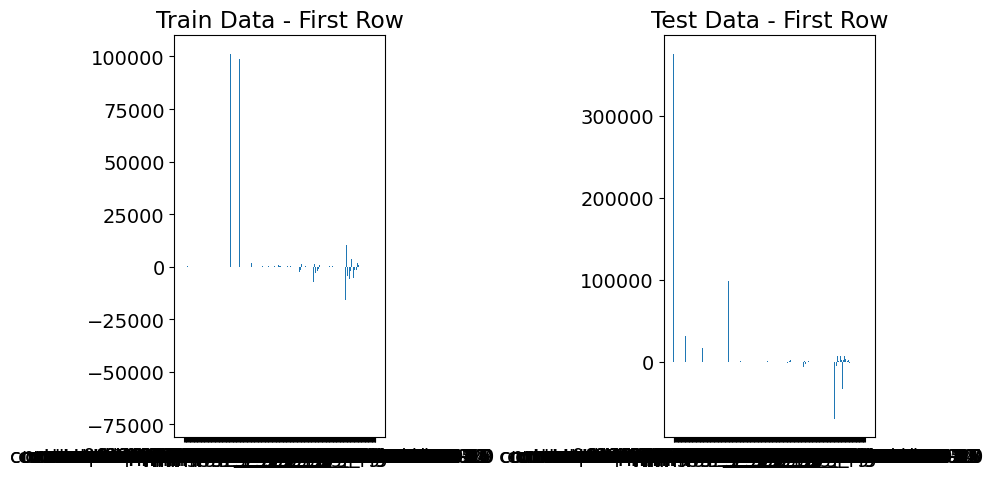

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert values to numeric (excluding non-numeric columns)
train_df_numeric = train_df.apply(pd.to_numeric, errors='coerce')

# Plotting using matplotlib
plt.figure(figsize=(10, 5))

# Plot for the first few rows of the train data
plt.subplot(1, 2, 1)
plt.bar(train_df_numeric.columns, train_df_numeric.iloc[0])
plt.title('Train Data - First Row')

# Convert values to numeric (excluding non-numeric columns)
test_df_numeric = test_df.apply(pd.to_numeric, errors='coerce')

# Plot for the first few rows of the test data
plt.subplot(1, 2, 2)
plt.bar(test_df_numeric.columns, test_df_numeric.iloc[0])
plt.title('Test Data - First Row')


plt.tight_layout()
plt.show()


- here we add a visual comparison of the first row of numeric data in the training and testing datasets using side-by-side bar plots.

We need to predict the following column:

In [ ]:
target = [c for c in train_df.columns if c not in test_df.columns][0]
print(target)

contest-tmp2m-14d__tmp2m


- This code is a way of determining the target variable for task. It assumes that the target variable is the only column present in the training dataset but not in the testing dataset. The identified target variable is then printed. The target variable is the variable that the model aims to predict.


Since we have a time series problem, let's change `startdate` to datetime format for easier handling.

In [ ]:
train_df.startdate = pd.to_datetime(train_df.startdate)
test_df.startdate = pd.to_datetime(test_df.startdate)

- this code is ensuring that the 'startdate' column in both the training and testing datasets is treated as datetime objects rather than plain strings or other data types. This conversion is important for any time-based analysis or modeling, allowing for easier manipulation, sorting, and extraction of date-related information.



# Exploratory Data Analysis (EDA)
Let's start with a basic EDA to get an overview of the data.

**Insight 1:** We have a time series problem but we have big time gap between the training and the testing data.

This might actually be the biggest challenge of this competition.

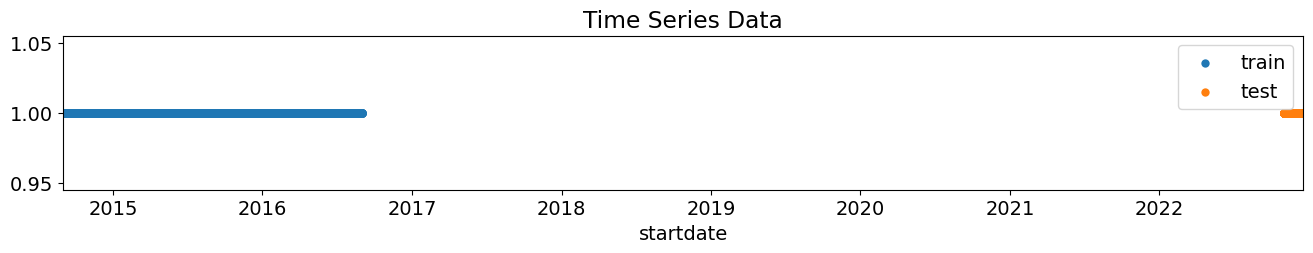

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,2))
ax.set_title('Time Series Data')
sns.scatterplot(data = train_df, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'train')
sns.scatterplot(data = test_df, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'test')
ax.set_xlim([train_df['startdate'].iloc[0], test_df['startdate'].iloc[-1]])
plt.show()

 - this code generates a time series scatter plot with markers representing data points from both the training and testing datasets. It visualizes how the data points are distributed over time, and the x-axis is labeled with dates. The legend distinguishes between the training and testing datasets. The plot has a specific size and title for better presentation.

    Good for showing individual data points.
    
    Useful for highlighting specific events or outliers.

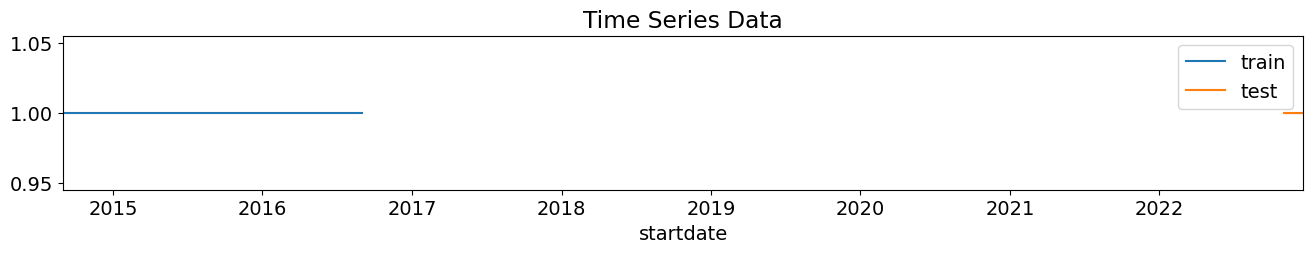

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(16, 2))
ax.set_title('Time Series Data')

# Plotting training data
sns.lineplot(data=train_df, x='startdate', y=1, label='train')

# Plotting testing data
sns.lineplot(data=test_df, x='startdate', y=1, label='test')

ax.set_xlim([train_df['startdate'].iloc[0], test_df['startdate'].iloc[-1]])
plt.show()

- here we add a code that generates a line plot to visualize the time series data from both the training and testing datasets on the same plot, making it easy to compare trends or patterns over time.

    Effective for showing trends and patterns over time.

    Provides a clear view of how the variable changes over the entire time period

**Insight 2**: For each date, we have 514 unique values. This means, we have 514 unique locations.

In [ ]:
train_df.groupby('startdate')[target].count()

startdate
2014-09-01    10
2014-09-02    10
2014-09-03    10
2014-09-04    10
2014-09-05    10
              ..
2016-08-27     9
2016-08-28     9
2016-08-29     9
2016-08-30     9
2016-08-31     9
Name: contest-tmp2m-14d__tmp2m, Length: 731, dtype: int64

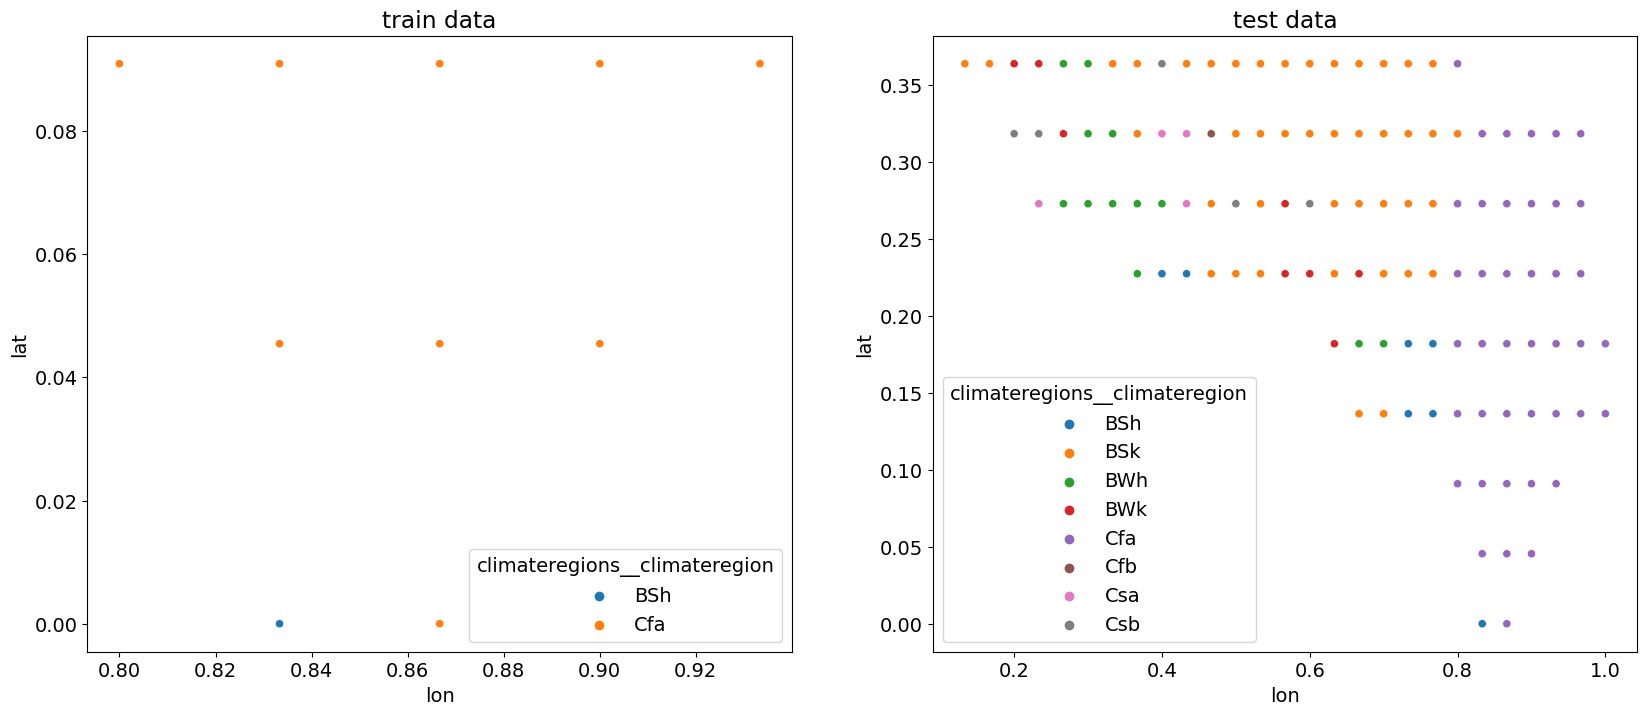

In [ ]:
temp = train_df.groupby(['climateregions__climateregion', 'lat', 'lon']).size().to_frame().reset_index(drop=False)
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.scatterplot(data=temp, y='lat', x='lon', hue='climateregions__climateregion', ax=ax[0])
ax[0].set_title('train data')
temp = test_df.groupby(['climateregions__climateregion', 'lat', 'lon']).size().to_frame().reset_index(drop=False)
sns.scatterplot(data=temp, y='lat', x='lon', hue='climateregions__climateregion', ax=ax[1])
ax[1].set_title('test data')
plt.show()

- this code provides visualizations for both temporal and geographical aspects of the data. The first subplot shows the count of occurrences of the target variable over time, and the second subplot shows scatter plots of geographical data for both the training and testing datasets.

Let's create a location feature from the lat/lon coordinates.

In [ ]:
# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

index       lat       lon  startdate  \
0          0  0.000000  0.833333 2014-09-01   
1          1  0.000000  0.833333 2014-09-02   
2          2  0.000000  0.833333 2014-09-03   
3          3  0.000000  0.833333 2014-09-04   
4          4  0.000000  0.833333 2014-09-05   
...      ...       ...       ...        ...   
7302  383036  0.363636  0.800000 2022-12-14   
7303  383037  0.363636  0.800000 2022-12-15   
7304  383038  0.363636  0.800000 2022-12-16   
7305  383039  0.363636  0.800000 2022-12-17   
7306  383040  0.363636  0.800000 2022-12-18   

      contest-pevpr-sfc-gauss-14d__pevpr  nmme0-tmp2m-34w__cancm30  \
0                                 237.00                     29.02   
1                                 228.90                     29.02   
2                                 220.69                     29.02   
3                                 225.28                     29.02   
4                                 237.24                     29.02   
...                                  ...                       ...   
7302                              421.43                     24.61   
7303                              435.71                     24.61   
7304                              439.12                     24.61   
7305                              410.98                     24.61   
7306                              373.54                     24.61   

      nmme0-tmp2m-34w__cancm40  nmme0-tmp2m-34w__ccsm30  \
0                        31.64                    29.57   
1                        31.64                    29.57   
2                        31.64                    29.57   
3                        31.64                    29.57   
4                        31.64                    29.57   
...                        ...                      ...   
7302                     28.06                    26.94   
7303                     28.06                    26.94   
7304                     28.06                    26.94   
7305                     28.06                    26.94   
7306                     28.06                    26.94   

      nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  ...  \
0                       30.73                    29.71  ...   
1                       30.73                    29.71  ...   
2                       30.73                    29.71  ...   
3                       30.73                    29.71  ...   
4                       30.73                    29.71  ...   
...                       ...                      ...  ...   
7302                    24.90                    22.18  ...   
7303                    24.90                    22.18  ...   
7304                    24.90                    22.18  ...   
7305                    24.90                    22.18  ...   
7306                    24.90                    22.18  ...   

      wind-vwnd-925-2010-12  wind-vwnd-925-2010-13  wind-vwnd-925-2010-14  \
0                    -37.21                   8.32                   9.56   
1                    -36.57                   8.77                  21.17   
2                    -34.16                   6.99                  32.16   
3                    -31.04                   6.17                  39.66   
4                    -31.80                   7.47                  38.62   
...                     ...                    ...                    ...   
7302                 -18.03                  68.24                  15.83   
7303                 -25.26                  72.13                  11.58   
7304                 -29.26                  72.92                  13.74   
7305                 -29.38                  73.15                  21.73   
7306                    NaN                    NaN                    NaN   

      wind-vwnd-925-2010-15  wind-vwnd-925-2010-16  wind-vwnd-925-2010-17  \
0                     -2.03                  48.13                  28.09   
1                      4.44                  48.60      

120 unique locations


- this code concatenates the training and testing datasets into a single DataFrame (`all_df`). It then creates a new feature called 'loc_group' based on the grouping of latitude and longitude. The number of unique locations is printed, and finally, the concatenated DataFrame is split back into training and testing datasets. The 'loc_group' feature is essentially assigning a unique identifier to each location based on its latitude and longitude.


**Insight 3:** We have different locations, between training and test data

In [ ]:
print('Locations in train that are not in test')
print([c for c in train_df.loc_group.unique() if c not in test_df.loc_group.unique()])

print('Locations in test that are not in train')
print([c for c in test_df.loc_group.unique() if c not in train_df.loc_group.unique()])

Locations in train that are not in test
[]
Locations in test that are not in train
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


- these prints and list comprehensions help identify and display locations in the training dataset that are not present in the testing dataset and vice versa. This can be useful for understanding the distribution and coverage of locations in the two datasets, especially when working with geospatial or location-based data.

[Flavia Felicioni](https://www.kaggle.com/flaviafelicioni) has investigated this issue in her notebook [WiDS 2023: different locations train/test SOLVED](https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved) and found that this issue is caused due to rounding differences between training and test data.

She proposes to truncate the original latitude/longitude coordinates and re-create the location features.

In [ ]:
scale = 14

train_df.loc[:,'lat']=round(train_df.lat,scale)
train_df.loc[:,'lon']=round(train_df.lon,scale)

test_df.loc[:,'lat']=round(test_df.lat,scale)
test_df.loc[:,'lon']=round(test_df.lon,scale)

# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

print('Locations in train that are not in test')
print([c for c in train_df.loc_group.unique() if c not in test_df.loc_group.unique()])

print('Locations in test that are not in train')
print([c for c in test_df.loc_group.unique() if c not in train_df.loc_group.unique()])

index       lat       lon  startdate  \
0          0  0.000000  0.833333 2014-09-01   
1          1  0.000000  0.833333 2014-09-02   
2          2  0.000000  0.833333 2014-09-03   
3          3  0.000000  0.833333 2014-09-04   
4          4  0.000000  0.833333 2014-09-05   
...      ...       ...       ...        ...   
7302  383036  0.363636  0.800000 2022-12-14   
7303  383037  0.363636  0.800000 2022-12-15   
7304  383038  0.363636  0.800000 2022-12-16   
7305  383039  0.363636  0.800000 2022-12-17   
7306  383040  0.363636  0.800000 2022-12-18   

      contest-pevpr-sfc-gauss-14d__pevpr  nmme0-tmp2m-34w__cancm30  \
0                                 237.00                     29.02   
1                                 228.90                     29.02   
2                                 220.69                     29.02   
3                                 225.28                     29.02   
4                                 237.24                     29.02   
...                                  ...                       ...   
7302                              421.43                     24.61   
7303                              435.71                     24.61   
7304                              439.12                     24.61   
7305                              410.98                     24.61   
7306                              373.54                     24.61   

      nmme0-tmp2m-34w__cancm40  nmme0-tmp2m-34w__ccsm30  \
0                        31.64                    29.57   
1                        31.64                    29.57   
2                        31.64                    29.57   
3                        31.64                    29.57   
4                        31.64                    29.57   
...                        ...                      ...   
7302                     28.06                    26.94   
7303                     28.06                    26.94   
7304                     28.06                    26.94   
7305                     28.06                    26.94   
7306                     28.06                    26.94   

      nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  ...  \
0                       30.73                    29.71  ...   
1                       30.73                    29.71  ...   
2                       30.73                    29.71  ...   
3                       30.73                    29.71  ...   
4                       30.73                    29.71  ...   
...                       ...                      ...  ...   
7302                    24.90                    22.18  ...   
7303                    24.90                    22.18  ...   
7304                    24.90                    22.18  ...   
7305                    24.90                    22.18  ...   
7306                    24.90                    22.18  ...   

      wind-vwnd-925-2010-12  wind-vwnd-925-2010-13  wind-vwnd-925-2010-14  \
0                    -37.21                   8.32                   9.56   
1                    -36.57                   8.77                  21.17   
2                    -34.16                   6.99                  32.16   
3                    -31.04                   6.17                  39.66   
4                    -31.80                   7.47                  38.62   
...                     ...                    ...                    ...   
7302                 -18.03                  68.24                  15.83   
7303                 -25.26                  72.13                  11.58   
7304                 -29.26                  72.92                  13.74   
7305                 -29.38                  73.15                  21.73   
7306                    NaN                    NaN                    NaN   

      wind-vwnd-925-2010-15  wind-vwnd-925-2010-16  wind-vwnd-925-2010-17  \
0                     -2.03                  48.13                  28.09   
1                      4.44                  48.60      

120 unique locations
Locations in train that are not in test
[]
Locations in test that are not in train
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


<Axes: xlabel='startdate', ylabel='contest-tmp2m-14d__tmp2m'>

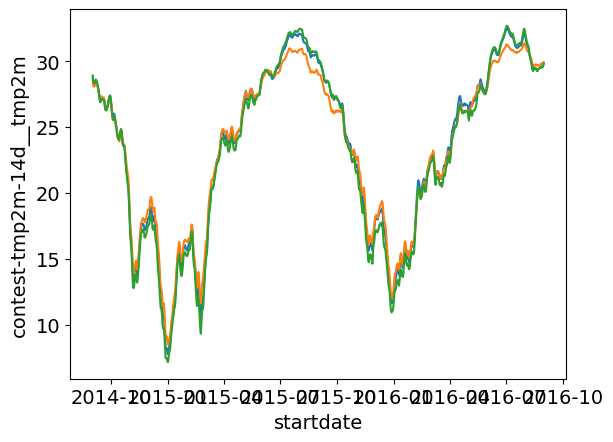

In [ ]:
temp = train_df[train_df.loc_group == 0]
sns.lineplot(data=temp, x = 'startdate', y = target)
temp = train_df[train_df.loc_group == 1]
sns.lineplot(data=temp, x = 'startdate', y = target)

temp = train_df[train_df.loc_group == 2]
sns.lineplot(data=temp, x = 'startdate', y = target)

- this code is rounding of latitude and longitude, concatenates training and testing datasets, creates a new feature 'loc_group' based on rounded latitude and longitude,

   prints the number of unique locations,

   splits the datasets back,

   checks for locations present in one dataset but not the other, and
  
   creates line plots for specific location groups in the training dataset.


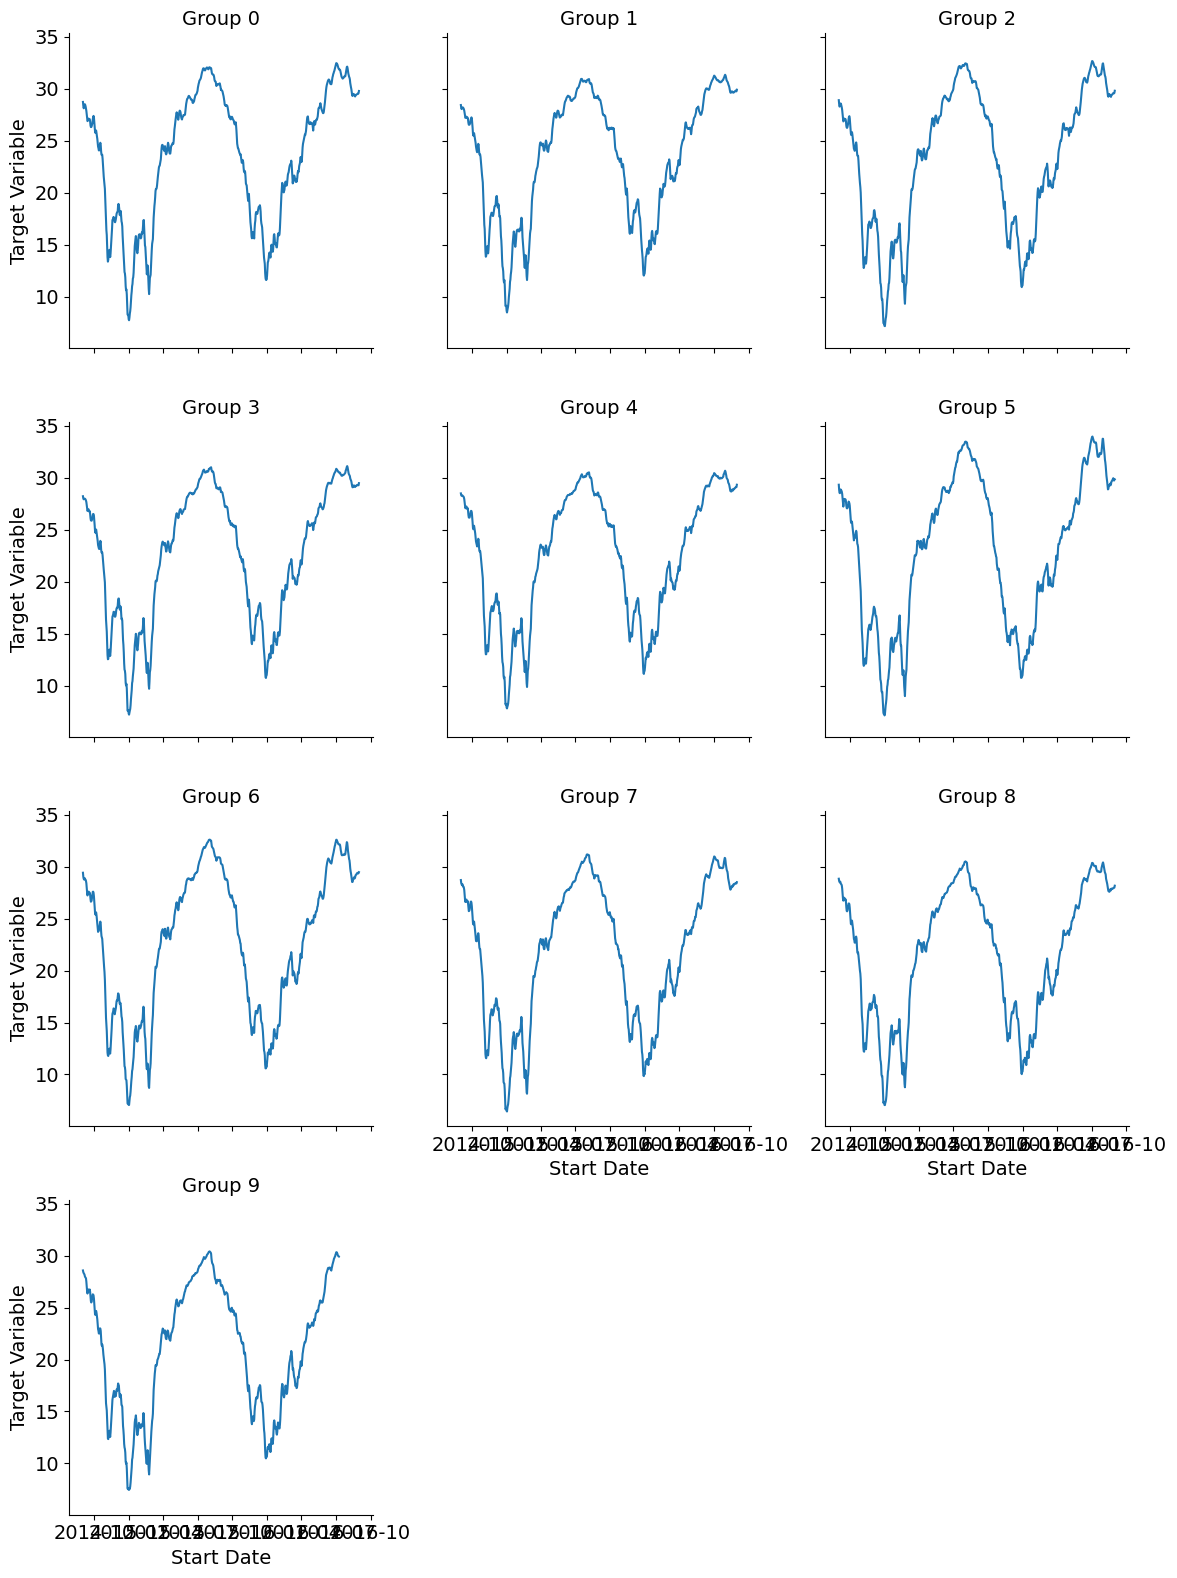

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_df' is your DataFrame, 'loc_group' is the column specifying groups, and 'target' is your target column

# Example data loading (replace this with your data loading logic)
# train_df = pd.read_csv('your_data.csv')

# Example plot
g = sns.FacetGrid(train_df, col='loc_group', col_wrap=3, height=4)
g.map(sns.lineplot, 'startdate', target)
g.set_axis_labels('Start Date', 'Target Variable')
g.set_titles(col_template='Group {col_name}')
plt.show()


# Preprocessing

Let's check if we have any missing data and how we can handle them.

As you can see below, we have a few columns in the training data (but not in the testing data) with missing values.

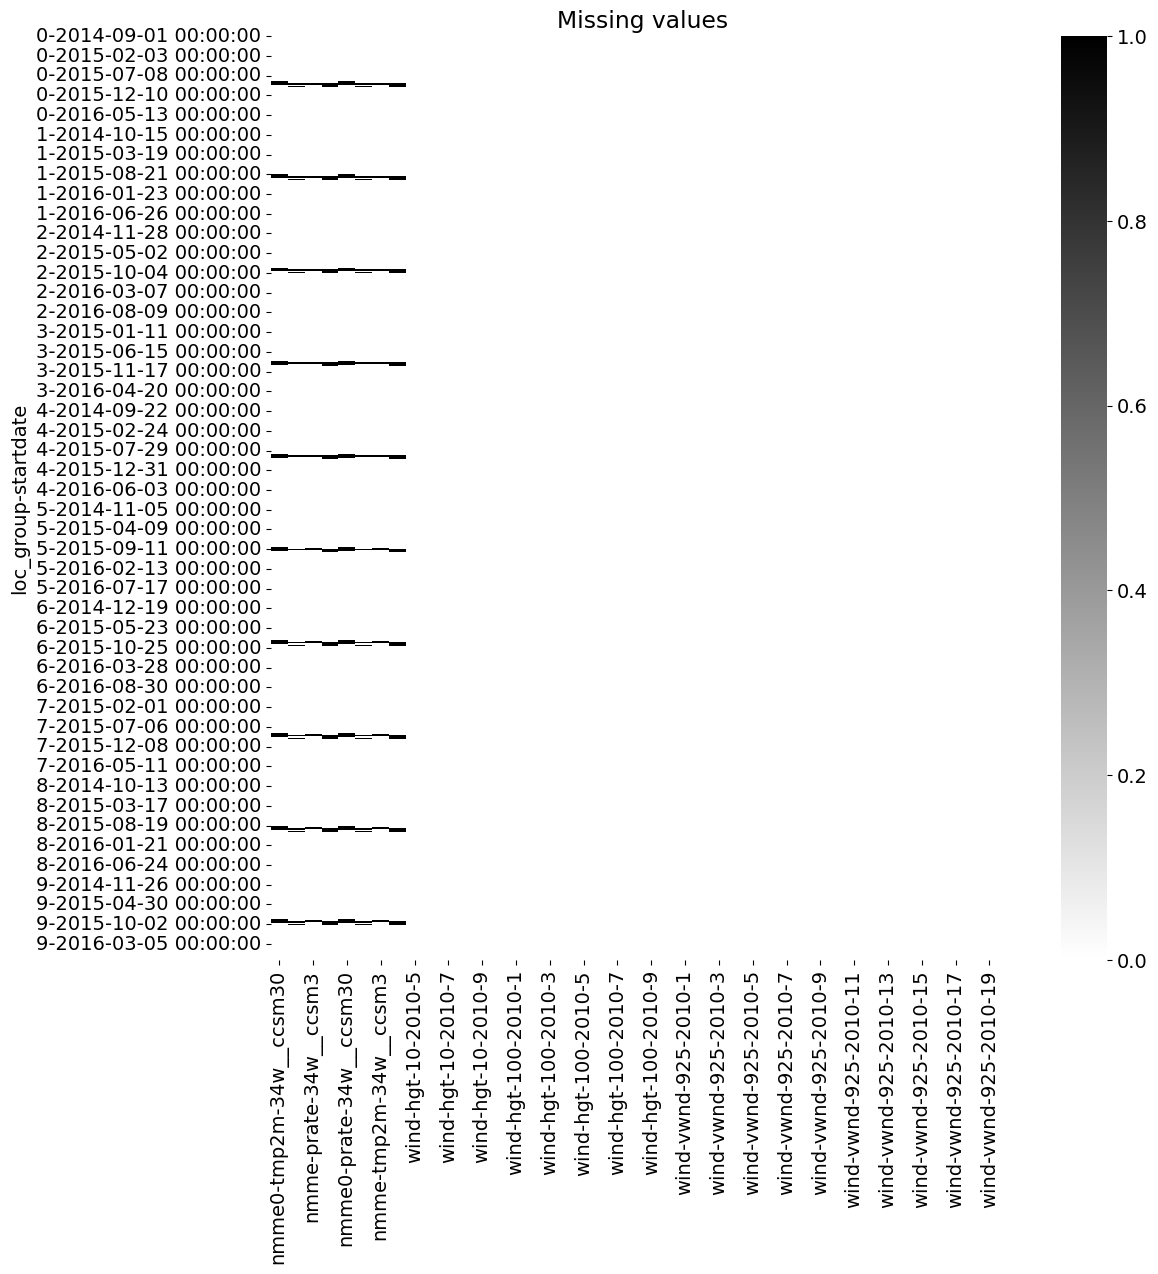

In [ ]:
cols_with_missing = list(train_df.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) > 0].index)

fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(train_df.set_index([ 'loc_group', 'startdate'])[cols_with_missing].isnull(), cmap='binary')
ax.set_title('Missing values')
plt.show()

- The code identifies columns in the "train_df" dataset that contain missing values and then plots a heatmap to visualize the locations of these missing values in those columns.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_df' is your DataFrame

cols_with_missing = train_df.columns[train_df.isnull().any()].tolist()

missing_counts = train_df[cols_with_missing].isnull().sum()
missing_percentages = (missing_counts / len(train_df)) * 100

# Check if there are non-empty values in missing_percentages
if not missing_percentages.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_percentages.index, y=missing_percentages)
    plt.xticks(rotation=45, ha='right')
    plt.title('Percentage of Missing Values')
    plt.ylabel('Percentage')
    plt.show()
else:
    print("No columns with missing values.")


No columns with missing values.


- here i tried to visuilize the missing valus in a bar plot but bc there missing there wouldnt be an colums

In [ ]:
# Save this for visualization purposes only and delete later
train_df_old = train_df.copy()
train_df_mean = train_df.sort_values(by=['loc_group', 'startdate']).fillna(20)

- The code creates a copy of the original DataFrame train_df for visualization purposes rain_df_old. It also generates a new DataFrame train_df_mean by filling missing values in the original DataFrame with a constant value of 20.

Often times in Machine Learning, missing values are filled with the mean value. But as you can see below in pink, filling missing values with the mean value is not ideal. Our human intuition tells us that the time series values should not drop down to the mean value where the data points are missing. Instead the values should probably be filled with some value between 27 and 30.

For this purpose, we can use the `.ffill()` method, which just uses the last observed value to fill the missing value.

This is a popular approach to fill missing values in time series forecasting. It is also similar to the naive forecasting method. In naive forecasts, the forecast is simply the observed value. Despite its simplicity, the naive approach is a difficult baseline to beat. But think about it: If you want to forecast tomorrow's weather, a good guess would be that it will be similar to today. If it snowed today, it is quite unlikely that it is going to be hot tomorrow.

In [ ]:
train_df = train_df.sort_values(by=['loc_group', 'startdate']).ffill()


- The code sorts the DataFrame train_df by loc_group and startdate and then forward-fills missing values.






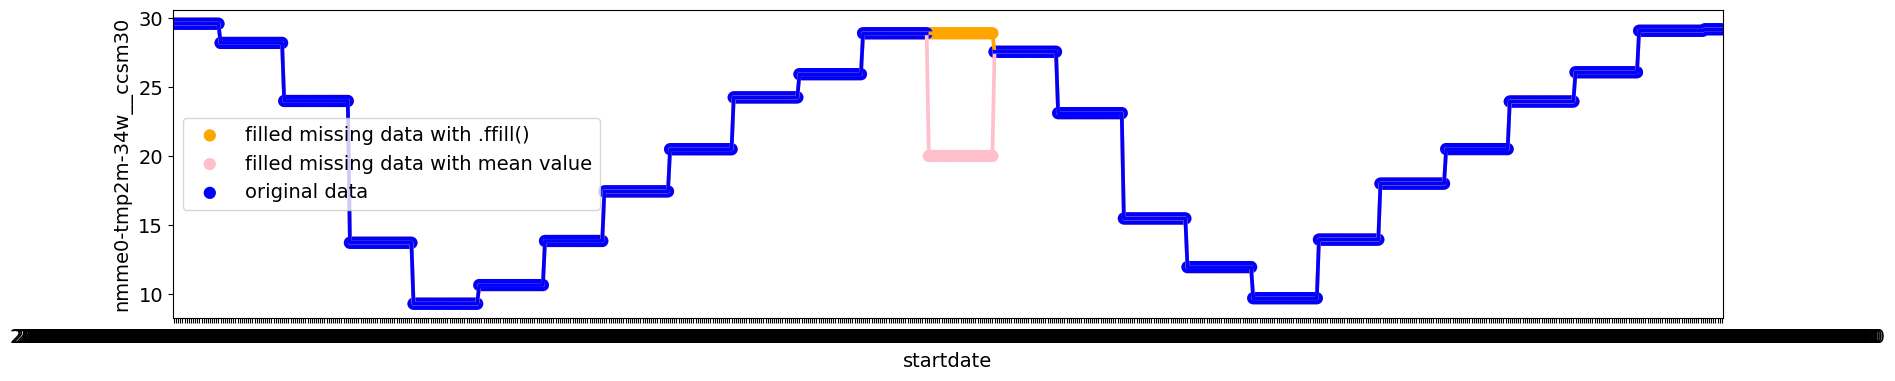

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(20,4))
col_with_missing = cols_with_missing[0]
sns.pointplot(data=train_df[train_df.loc_group ==0], x='startdate', y=col_with_missing, color='orange', label='filled missing data with .ffill()')
sns.pointplot(data=train_df_mean[train_df_mean.loc_group ==0], x='startdate', y=col_with_missing, color='pink', label='filled missing data with mean value' )
sns.pointplot(data=train_df_old[train_df_old.loc_group ==0], x='startdate', y=col_with_missing, color='blue', label='original data' )

plt.legend()
plt.show()

del train_df_old, train_df_mean

- The code plots points for specific values over time (using the `startdate` time period). It compares the original data with data after filling missing values using `.ffill()` and with the mean value. After plotting, temporary data (`train_df_old` and `train_df_mean`) is deleted.

# Feature Engineering
Let's start with some basic features

## Label Encoding

## Time Features

In [ ]:
def create_time_features(df):
    df = df.copy()
    #df['year'] = df.startdate.dt.year
    df['quarter'] = df.startdate.dt.quarter
    df['month'] = df.startdate.dt.month
    df['week'] = df.startdate.dt.weekofyear
    df['dayofyear'] = df.startdate.dt.day_of_year
    return df

train_df = create_time_features(train_df)
test_df = create_time_features(test_df)
train_df.head()

index  lat       lon  startdate  contest-pevpr-sfc-gauss-14d__pevpr  \
0      0  0.0  0.833333 2014-09-01                              237.00   
1      1  0.0  0.833333 2014-09-02                              228.90   
2      2  0.0  0.833333 2014-09-03                              220.69   
3      3  0.0  0.833333 2014-09-04                              225.28   
4      4  0.0  0.833333 2014-09-05                              237.24   

   nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
0                     29.02                     31.64   
1                     29.02                     31.64   
2                     29.02                     31.64   
3                     29.02                     31.64   
4                     29.02                     31.64   

   nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  \
0                    29.57                    30.73                    29.71   
1                    29.57                    30.73                    29.71   
2                    29.57                    30.73                    29.71   
3                    29.57                    30.73                    29.71   
4                    29.57                    30.73                    29.71   

   ...  wind-vwnd-925-2010-16  wind-vwnd-925-2010-17  wind-vwnd-925-2010-18  \
0  ...                  48.13                  28.09                 -13.50   
1  ...                  48.60                  27.41                 -23.77   
2  ...                  48.53                  19.21                 -33.16   
3  ...                  50.59                   8.29                 -37.22   
4  ...                  54.73                  -2.58                 -42.30   

   wind-vwnd-925-2010-19  wind-vwnd-925-2010-20  loc_group  quarter  month  \
0                  11.90                   4.58          0        3      9   
1                  15.44                   3.42          0        3      9   
2                  15.11                   4.82          0        3      9   
3                  18.24                   9.74          0        3      9   
4                  21.91                  10.95          0        3      9   

   week  dayofyear  
0    36        244  
1    36        245  
2    36        246  
3    36        247  
4    36        248  

[5 rows x 251 columns]

- The code uses scikit-learn's `LabelEncoder` to transform categorical labels in the 'climateregions__climateregion' column of both the training and test datasets into numerical values.

In [ ]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def add_season(df):
    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2,
      9: 3,
      10: 3,
      11: 3,
      12: 0
  }
    df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(train_df)
add_season(test_df)

- The code defines a function, add_season, that maps months to seasons and adds a new 'season' column to a DataFrame based on the 'month' column. This function is then applied to both the training (train_df) and test (test_df) datasets.

In [ ]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

    # encode the week with a period of 52
    df['week_sin'] = sin_transformer(52).fit_transform(df['week'])
    df['week_cos'] = cos_transformer(52).fit_transform(df['week'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    # encode the season with a period of 4
    df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
    df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

    # encode the quarter with a period of 4
    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

encode_cyclical(train_df)
encode_cyclical(test_df)

- The code defines sine and cosine transformers and uses them to encode cyclical features (day of the year, week, month, season, and quarter) in both the `train_df` and `test_df` DataFrames.

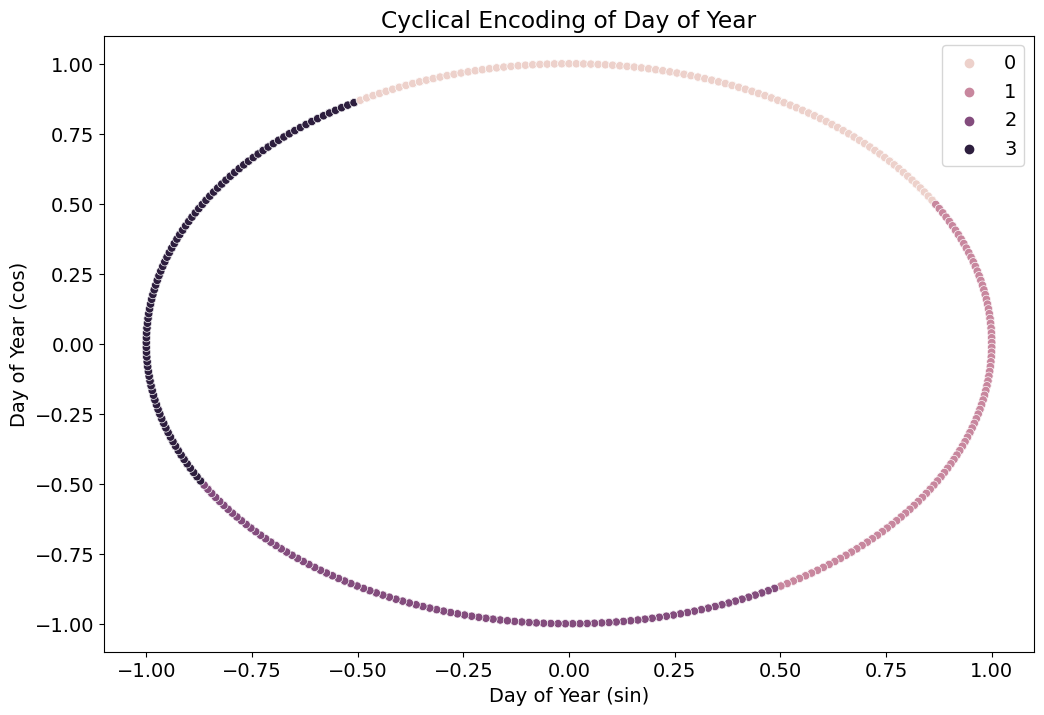

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_df' is your DataFrame with the cyclical features

plt.figure(figsize=(12, 8))
sns.scatterplot(x='day_of_year_sin', y='day_of_year_cos', data=train_df, hue='season')
plt.title('Cyclical Encoding of Day of Year')
plt.xlabel('Day of Year (sin)')
plt.ylabel('Day of Year (cos)')
plt.legend()
plt.show()


- here we add This scatter plot to show the relationship between the sin and cos transformations of the 'day_of_year' feature.

In [ ]:
"""# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['target_loc_group_max'] = all_df.groupby(['loc_group'])[target].transform('max')
all_df['target_loc_group_min'] = all_df.groupby(['loc_group'])[target].transform('min')
all_df['target_loc_group_std'] = all_df.groupby(['loc_group'])[target].transform('std')
all_df['target_loc_group_mean'] = all_df.groupby(['loc_group'])[target].transform('mean')

all_df['target_cr_max'] = all_df.groupby(['climateregions__climateregion'])[target].transform('max')
all_df['target_cr_min'] = all_df.groupby(['climateregions__climateregion'])[target].transform('min')
all_df['target_cr_std'] = all_df.groupby(['climateregions__climateregion'])[target].transform('std')
all_df['target_cr_mean'] = all_df.groupby(['climateregions__climateregion'])[target].transform('mean')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]"""

"# Concatenate train and test data\nall_df = pd.concat([train_df, test_df], axis=0)\n\n# Create new feature\nall_df['target_loc_group_max'] = all_df.groupby(['loc_group'])[target].transform('max')\nall_df['target_loc_group_min'] = all_df.groupby(['loc_group'])[target].transform('min')\nall_df['target_loc_group_std'] = all_df.groupby(['loc_group'])[target].transform('std')\nall_df['target_loc_group_mean'] = all_df.groupby(['loc_group'])[target].transform('mean')\n\nall_df['target_cr_max'] = all_df.groupby(['climateregions__climateregion'])[target].transform('max')\nall_df['target_cr_min'] = all_df.groupby(['climateregions__climateregion'])[target].transform('min')\nall_df['target_cr_std'] = all_df.groupby(['climateregions__climateregion'])[target].transform('std')\nall_df['target_cr_mean'] = all_df.groupby(['climateregions__climateregion'])[target].transform('mean')\n\n# Split back up\ntrain_df = all_df.iloc[:len(train_df)]\ntest_df = all_df.iloc[len(train_df):]"

- The code consolidates and augments data, extracting insightful statistics for the target variable based on location and climate region grouping, before redividing the data into training and testing sets.

- This code displays information on the top 10 location groups with the highest RMSE and generates detailed plots for the top 3 groups.

# Hyperparameter Tuning

Once the baseline is ready, we can approach hyperparameter tuning. Since I have already setup W&B for experiment tracking, I will also use it for hyperparameter tuning. If you don't have an W&B account, you can use other alternatives, like e.g. optuna.

I will be using random search to optimize the hyperparameters. To enable hyperparameter tuning, set `hyperparameter_tuning = True` in the following code block. I have disabled it here, so it doesn't run everytime I run this Notebook.

In [ ]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = False

def main():
    run = wandb.init(config = config)

    # note that we define values from `wandb.config` instead
    # of defining hard values
    params = {
        'metric': 'rmse',
        'objective': 'regression',
        'force_col_wise' : True,
        'seed': config['seed'],
        'learning_rate': run.config.learning_rate,
        'max_depth': run.config.max_depth,
        'lambda_l1': run.config.lambda_l1,
        'lambda_l2': run.config.lambda_l2,
        'num_leaves': run.config.num_leaves,
    }

    model = lgb.train(params,
                    train_ds,
                    num_boost_round = 1000,
                    valid_sets = [train_ds, valid_ds],
                      callbacks=[wandb_callback()],
                    early_stopping_rounds = 100,
                   verbose_eval = 100
                   )

    preds = model.predict(X_val)

    val_rmse = mean_squared_error(val[target].values,
                                               preds,
                                               squared=False)

    print(f'Validation RMSE: {val_rmse:.4f}')
    wandb.log({"val_rmse" : val_rmse})


# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'sweep_grid',
    "parameters" : {
        "learning_rate": {
            "min": 0.001,
            "max": 0.5
        },
        "max_depth": {
            "min": 4,
            "max": 32
        },
        "lambda_l1": {
            "min": 0,
            "max": 100
        },
        "lambda_l2": {
            "min": 0,
            "max": 100
        },
        "num_leaves": {
            "min": 4,
            "max": 64
        },
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project="WiDS-Datathon-2023",)

    # Start sweep job.
    wandb.agent(sweep_id, function=main)

- This code sets up hyperparameter tuning using Weights & Biases (W&B) for a LightGBM regression model. It defines a main function for training and logs results to W&B. The hyperparameter sweep configuration includes ranges for learning rate, max depth, lambda values, and number of leaves. The code executes the hyperparameter sweep if the flag `hyperparameter_tuning` is `True`; otherwise, it runs the main function with fixed hyperparameters.

# Prediction & Submission
Now, we are ready to make the predictions and submit them.

In [ ]:
submission = pd.read_csv('/content/sample_data/sample_solution.csv')
display(submission)

submission.to_csv('submission',
                  index = False) # Set index to false to avoid issues in evaluation

contest-tmp2m-14d__tmp2m   index
0                     27.073876  375734
1                     25.109308  375735
2                     22.557390  375736
3                     25.572875  375737
4                     20.781073  375738
...                         ...     ...
31349                 28.303967  407083
31350                 26.635933  407084
31351                 27.057762  407085
31352                 26.871066  407086
31353                 21.253714  407087

[31354 rows x 2 columns]

from matplotlib import pyplot as plt
submission['contest-tmp2m-14d__tmp2m'].plot(kind='hist', bins=20, title='contest-tmp2m-14d__tmp2m')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission.plot(kind='scatter', x='contest-tmp2m-14d__tmp2m', y='index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['contest-tmp2m-14d__tmp2m']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('contest-tmp2m-14d__tmp2m')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
submission['contest-tmp2m-14d__tmp2m'].plot(kind='line', figsize=(8, 4), title='contest-tmp2m-14d__tmp2m')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
submission['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['level_0'].plot(kind='hist', bins=20, title='level_0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['contest-tmp2m-14d__tmp2m'].plot(kind='hist', bins=20, title='contest-tmp2m-14d__tmp2m')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='level_0', y='contest-tmp2m-14d__tmp2m', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='contest-tmp2m-14d__tmp2m', y='index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['level_0']
  ys = series['contest-tmp2m-14d__tmp2m']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('level_0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('level_0')
_ = plt.ylabel('contest-tmp2m-14d__tmp2m')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['level_0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'level_0'}, axis=1)
              .sort_values('level_0', ascending=True))
  xs = counted['level_0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('level_0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('level_0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['contest-tmp2m-14d__tmp2m']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('contest-tmp2m-14d__tmp2m')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['level_0'].plot(kind='line', figsize=(8, 4), title='level_0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['contest-tmp2m-14d__tmp2m'].plot(kind='line', figsize=(8, 4), title='contest-tmp2m-14d__tmp2m')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

-  this code reads a sample CSV file into a DataFrame, displays the contents of the DataFrame, and  writes the DataFrame to a new CSV file without including the index column.